## Problem 1. VoxelMorph for Brain Registration (35 points)
Although most people’s brains are similar (e.g. everyone has a cingulate gyrus and a corpus callosum), there are also differences in brain size and shape. Hence, if we want to do a group analysis we need to ensure that each voxel for each subject corresponds to the same part of the brains of others. If we are measuring a voxel in the visual cortex, for example, we would want to make sure that every subject’s visual cortex is in alignment with that of another subject. This is done by registering the images. Just as you would fold clothes to fit them inside a suitcase, the brain images of different subjects need to be transformed to have the same size, shape, and dimensions. We do this by normalizing (or warping) the images to a template. A template is a brain image that has standard dimensions and coordinates. Most researchers have agreed to use the templates when reporting their results. 
#### Reference：
 "VoxelMorph: A Learning Framework for Deformable Medical Image Registration" (https://arxiv.org/pdf/1809.05231.pdf).
#### Requirement：
All your code should be shown in *problem1.ipynb* (this file). 

### 1.1 Data loading and preprocessing (6 points)
Use "SimpleITK" to load the data and resize it to \[64, 64, 64\].

In [1]:
# 读取数据，并且重采样
import os 
import SimpleITK as sitk
import numpy as np

#先完成读数据的部分，封装成函数能够让主程序看起来清晰易懂
def read_image_itk(path):
    imgdir = os.listdir(path)
    itkImgs = []
    imgArrays = []
    spacings = []
    directions = []
    origins = []
#     print(path)
    for filename in imgdir:
#         print(filename)
        itk_img = sitk.ReadImage(path + filename)
        #读取图像大小
        img_array = sitk.GetArrayFromImage(itk_img) # 新增一个通道的维度
#         print("Img array: ", img_array.shape)               
        #读取图像原点坐标
        origin = np.array(itk_img.GetOrigin())           
#         print("Origin (x,y,z): ", origin)
        #读取图像方向,采用方向余弦矩阵，也就是图像自身坐标系相对于世界坐标系（固定不动的）的角度，再直白点就是新坐标系在原坐标系上各个方向的投影
        direction = np.array(itk_img.GetDirection())
#         print("Direction: ", direction)
        # 读取图像尺度信息,图像各维度上像素之间的距离（物理层面的，有单位，一般为mm)
        spacing = np.array(itk_img.GetSpacing())         
#         print("Spacing (x,y,z): ", spacing)
        itkImgs.append(itk_img)
        imgArrays.append(img_array)
        origins.append(origin)
        directions.append(direction)
        spacings.append(spacing)
    print('数据读取完毕')
    return itkImgs,imgArrays,origins,directions,spacings
#数据读取函数写完了，返回了常用的几种信息，print部分先注释了，调试的时候再看吧

#resize部分
# 加了一个维度
def resize_image_itk(itkImgs, newSize, resamplemethod=sitk.sitkNearestNeighbor):
    itkimgResampleds=[]
    for itk_img in itkImgs:
        resampler = sitk.ResampleImageFilter()
        originSize = itk_img.GetSize()  # 原来的体素块尺寸
        originSpacing = itk_img.GetSpacing()   # 读取图像尺度信息,图像各维度上像素之间的距离（物理层面的，有单位，一般为mm)
        newSize = np.array(newSize,float)
        factor = originSize / newSize
        newSpacing = originSpacing * factor
        newSize = newSize.astype(np.int) #spacing肯定不能是整数
        resampler.SetReferenceImage(itk_img)  # 需要重新采样的目标图像
        resampler.SetSize(newSize.tolist())
        resampler.SetOutputSpacing(newSpacing.tolist())
        resampler.SetTransform(sitk.Transform(3, sitk.sitkIdentity))
        resampler.SetInterpolator(resamplemethod)  #这里要注意：mask用最近邻插值，CT图像用线性插值
#         itkimgResampled = resampler.Execute(itk_img)
        itkimgResampled = sitk.GetArrayFromImage(resampler.Execute(itk_img))[np.newaxis, ...]  # 得到重新采样后的图像
        itkimgResampleds.append(itkimgResampled)
    print('数据resize完毕')
    return itkimgResampleds
# 加了两个维度
def resize_fixed_itk(itk_img, newSize, resamplemethod=sitk.sitkNearestNeighbor):
    itkimgResampleds=[]
    resampler = sitk.ResampleImageFilter()
    originSize = itk_img.GetSize()  # 原来的体素块尺寸
    originSpacing = itk_img.GetSpacing()   # 读取图像尺度信息,图像各维度上像素之间的距离（物理层面的，有单位，一般为mm)
    newSize = np.array(newSize,float)
    factor = originSize / newSize
    newSpacing = originSpacing * factor
    newSize = newSize.astype(np.int) #spacing肯定不能是整数
    resampler.SetReferenceImage(itk_img)  # 需要重新采样的目标图像
    resampler.SetSize(newSize.tolist())
    resampler.SetOutputSpacing(newSpacing.tolist())
    resampler.SetTransform(sitk.Transform(3, sitk.sitkIdentity))
    resampler.SetInterpolator(resamplemethod)  #这里要注意：mask用最近邻插值，CT图像用线性插值
    itkimgResampled = sitk.GetArrayFromImage(resampler.Execute(itk_img))[np.newaxis, np.newaxis, ...] # 得到重新采样后的图像
    print('fixed图像resize完毕')
    return itkimgResampled

# 一些参数设置
train_path='./data/train/'
mask_path='./data/mask/'
atlas_path='./data/fixed.nii.gz'
model_dir = './model/'
newSize=[64,64,64]
#读取和resize
trainItkImgs,trainImgArrays,trainOrigins,trainDirections,trainSpacings=read_image_itk(train_path)
maskItkImgs,maskImgArrays,maskOrigins,maskDirections,maskSpacings=read_image_itk(mask_path)
trainItkImgsResized=resize_image_itk(trainItkImgs, newSize, resamplemethod=sitk.sitkLinear)
maskItkImgsResized=resize_image_itk(maskItkImgs, newSize, resamplemethod=sitk.sitkNearestNeighbor)
fixedImg=resize_fixed_itk(sitk.ReadImage(atlas_path),newSize, resamplemethod=sitk.sitkLinear)

数据读取完毕
数据读取完毕
数据resize完毕
数据resize完毕
fixed图像resize完毕


### 1.2 Building the VoxelMorph model (6 points)
Hint: You can refer to the original VoxelMorph model in the reference above.

In [2]:
# 设置各种参数
# 公共参数
gpu='0' #选哪个gpu跑
atlas_file='./data/fixed.nii.gz' #模板/地图路径
result_dir='./result' #图像存放路径

# 训练参数
train_dir='./data/train/' #数据路径
lr=1e-4 #学习率
n_iter=15000 #迭代次数
sim_loss='ncc' #损失函数，用来评估预测结果与输入的相似程度
alpha=1 #平滑损失占总损失函数中的比例
batch_size=1 #批大小
n_save_iter=5000 #每几次迭代保存模型
model_dir='./models/' #模型存储路径

In [3]:
# 定义模型结构
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal

# 定义Unet
class U_Network(nn.Module):
    def __init__(self, dim, enc_nf, dec_nf, bn=None, full_size=True):
        super(U_Network, self).__init__()
        self.bn = bn
        self.dim = dim
        self.enc_nf = enc_nf
        self.full_size = full_size
        self.vm2 = len(dec_nf) == 7
        # Encoder functions
        self.enc = nn.ModuleList()
        for i in range(len(enc_nf)):
            prev_nf = 2 if i == 0 else enc_nf[i - 1]
            self.enc.append(self.conv_block(dim, prev_nf, enc_nf[i], 4, 2, batchnorm=bn))
        # Decoder functions
        self.dec = nn.ModuleList()
        self.dec.append(self.conv_block(dim, enc_nf[-1], dec_nf[0], batchnorm=bn))  # 1
        self.dec.append(self.conv_block(dim, dec_nf[0] * 2, dec_nf[1], batchnorm=bn))  # 2
        self.dec.append(self.conv_block(dim, dec_nf[1] * 2, dec_nf[2], batchnorm=bn))  # 3
        self.dec.append(self.conv_block(dim, dec_nf[2] + enc_nf[0], dec_nf[3], batchnorm=bn))  # 4
        self.dec.append(self.conv_block(dim, dec_nf[3], dec_nf[4], batchnorm=bn))  # 5

        if self.full_size:
            self.dec.append(self.conv_block(dim, dec_nf[4] + 2, dec_nf[5], batchnorm=bn))
        if self.vm2:
            self.vm2_conv = self.conv_block(dim, dec_nf[5], dec_nf[6], batchnorm=bn)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        # One conv to get the flow field
        conv_fn = getattr(nn, 'Conv%dd' % dim)
        self.flow = conv_fn(dec_nf[-1], dim, kernel_size=3, padding=1)
        # Make flow weights + bias small. Not sure this is necessary.
        nd = Normal(0, 1e-5)
        self.flow.weight = nn.Parameter(nd.sample(self.flow.weight.shape))
        self.flow.bias = nn.Parameter(torch.zeros(self.flow.bias.shape))
        self.batch_norm = getattr(nn, "BatchNorm{0}d".format(dim))(3)

    def conv_block(self, dim, in_channels, out_channels, kernel_size=3, stride=1, padding=1, batchnorm=False):
        conv_fn = getattr(nn, "Conv{0}d".format(dim))
        bn_fn = getattr(nn, "BatchNorm{0}d".format(dim))
        if batchnorm:
            layer = nn.Sequential(
                conv_fn(in_channels, out_channels, kernel_size, stride=stride, padding=padding),
                bn_fn(out_channels),
                nn.LeakyReLU(0.2))
        else:
            layer = nn.Sequential(
                conv_fn(in_channels, out_channels, kernel_size, stride=stride, padding=padding),
                nn.LeakyReLU(0.2))
        return layer

    def forward(self, src, tgt):
        x = torch.cat([src, tgt], dim=1)
        # Get encoder activations
        x_enc = [x]
        for i, l in enumerate(self.enc):
            x = l(x_enc[-1])
            x_enc.append(x)
        # Three conv + upsample + concatenate series
        y = x_enc[-1]
        for i in range(3):
            y = self.dec[i](y)
            y = self.upsample(y)
            y = torch.cat([y, x_enc[-(i + 2)]], dim=1)
        # Two convs at full_size/2 res
        y = self.dec[3](y)
        y = self.dec[4](y)
        # Upsample to full res, concatenate and conv
        if self.full_size:
            y = self.upsample(y)
            y = torch.cat([y, x_enc[0]], dim=1)
            y = self.dec[5](y)
        # Extra conv for vm2
        if self.vm2:
            y = self.vm2_conv(y)
        flow = self.flow(y)
        if self.bn:
            flow = self.batch_norm(flow)
        return flow

# 定义形变场
class SpatialTransformer(nn.Module):
    def __init__(self, size, mode='bilinear'):
        super(SpatialTransformer, self).__init__()
        # Create sampling grid
        vectors = [torch.arange(0, s) for s in size]
        grids = torch.meshgrid(vectors)
        grid = torch.stack(grids)  # y, x, z
        grid = torch.unsqueeze(grid, 0)  # add batch
        grid = grid.type(torch.FloatTensor)
        self.register_buffer('grid', grid)

        self.mode = mode

    def forward(self, src, flow):
        new_locs = self.grid + flow
        shape = flow.shape[2:]

        # Need to normalize grid values to [-1, 1] for resampler
        for i in range(len(shape)):
            new_locs[:, i, ...] = 2 * (new_locs[:, i, ...] / (shape[i] - 1) - 0.5)

        if len(shape) == 2:
            new_locs = new_locs.permute(0, 2, 3, 1)
            new_locs = new_locs[..., [1, 0]]
        elif len(shape) == 3:
            new_locs = new_locs.permute(0, 2, 3, 4, 1)
            new_locs = new_locs[..., [2, 1, 0]]

        return F.grid_sample(src, new_locs, mode=self.mode)

### 1.3 Defining loss function (8 points)
Use NCC (Normalized Cross Correlation) as "similarity_loss" and Jacobian constraint as "smooth_loss".

In [4]:
# 定义损失函数
import math
import torch
import numpy as np
import torch.nn.functional as F

# 形变损失

def compute_local_sums(I, J, filt, stride, padding, win):
    I2, J2, IJ = I * I, J * J, I * J
    I_sum = F.conv3d(I, filt, stride=stride, padding=padding)
    J_sum = F.conv3d(J, filt, stride=stride, padding=padding)
    I2_sum = F.conv3d(I2, filt, stride=stride, padding=padding)
    J2_sum = F.conv3d(J2, filt, stride=stride, padding=padding)
    IJ_sum = F.conv3d(IJ, filt, stride=stride, padding=padding)
    win_size = np.prod(win)
    u_I = I_sum / win_size
    u_J = J_sum / win_size
    cross = IJ_sum - u_J * I_sum - u_I * J_sum + u_I * u_J * win_size
    I_var = I2_sum - 2 * u_I * I_sum + u_I * u_I * win_size
    J_var = J2_sum - 2 * u_J * J_sum + u_J * u_J * win_size
    return I_var, J_var, cross

def ncc_loss(I, J, win=None):
    '''
    输入大小是[B,C,D,W,H]格式的，在计算ncc时用卷积来实现指定窗口内求和
    '''
    ndims = len(list(I.size())) - 2
    assert ndims in [1, 2, 3], "volumes should be 1 to 3 dimensions. found: %d" % ndims
    if win is None:
        win = [9] * ndims
    sum_filt = torch.ones([1, 1, *win]).to("cuda:{}".format(gpu))
    pad_no = math.floor(win[0] / 2)
    stride = [1] * ndims
    padding = [pad_no] * ndims
    I_var, J_var, cross = compute_local_sums(I, J, sum_filt, stride, padding, win)
    cc = cross * cross / (I_var * J_var + 1e-5)
    return -1 * torch.mean(cc)

def Get_Ja(flow):
    '''
    Calculate the Jacobian value at each point of the displacement map having
    size of b*h*w*d*3 and in the cubic volumn of [-1, 1]^3
    '''
    D_y = (flow[:, 1:, :-1, :-1, :] - flow[:, :-1, :-1, :-1, :])
    D_x = (flow[:, :-1, 1:, :-1, :] - flow[:, :-1, :-1, :-1, :])
    D_z = (flow[:, :-1, :-1, 1:, :] - flow[:, :-1, :-1, :-1, :])
    D1 = (D_x[..., 0] + 1) * ((D_y[..., 1] + 1) * (D_z[..., 2] + 1) - D_z[..., 1] * D_y[..., 2])
    D2 = (D_x[..., 1]) * (D_y[..., 0] * (D_z[..., 2] + 1) - D_y[..., 2] * D_x[..., 0])
    D3 = (D_x[..., 2]) * (D_y[..., 0] * D_z[..., 1] - (D_y[..., 1] + 1) * D_z[..., 0])
    return D1 - D2 + D3

def NJ_loss(ypred):
    '''
    Penalizing locations where Jacobian has negative determinants
    '''
    Neg_Jac = 0.5 * (torch.abs(Get_Ja(ypred)) - Get_Ja(ypred))
    return torch.sum(Neg_Jac)

### 1.4 Model training (8 points)
The number of training iterations should be 15000. Save the results (the warped image and deformation field) every 5000 iterations.

In [5]:
# 模型训练
# python imports
import os
import glob
import warnings
# external imports外源调用
import torch
import numpy as np
import SimpleITK as sitk
from torch.optim import Adam
import torch.utils.data as Data
from tqdm import tqdm

# 如果没有，生成文件夹，不重要
def make_dirs():
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)

# 保存图像的函数
def save_image(img, ref_img, name):
    img = sitk.GetImageFromArray(img[0, ...].cpu().detach().numpy())
    img.SetOrigin(ref_img.GetOrigin())
    img.SetDirection(ref_img.GetDirection())
    img.SetSpacing(ref_img.GetSpacing())
    sitk.WriteImage(img, os.path.join(result_dir, name))


# 创建需要的文件夹并指定gpu
make_dirs()
device = torch.device('cuda:{}'.format(gpu) if torch.cuda.is_available() else 'cpu')

# 读入fixed图像
# f_img = sitk.ReadImage(atlas_file)
f_img = sitk.GetImageFromArray(fixedImg[0,0,:,:,:])
input_fixed=np.array(fixedImg)
# 确定图像维度，本题是3维
vol_size = input_fixed.shape[2:]
# [B, C, D, W, H]【图像数/batch，通道，长，宽，高】
# 把配准图像重复‘图像个数’次
input_fixed = np.repeat(input_fixed, batch_size, axis=0)
input_fixed = torch.from_numpy(input_fixed).to(device).float()

# 创建配准网络（UNet）和STN形变场
nf_enc = [16, 32, 32, 32]
# 设置解码器网络结构参数
nf_dec = [32, 32, 32, 32, 32, 16, 16]
# 初始化Unet和形变场
UNet = U_Network(len(vol_size), nf_enc, nf_dec).to(device)
STN = SpatialTransformer(vol_size).to(device)

# 设置优化器和损失函数
opt = Adam(UNet.parameters(), lr=lr)
sim_loss_fn = ncc_loss
smooth_loss_fn = NJ_loss

# Get all the names of the training data
DS=torch.tensor(trainItkImgsResized)
print("Number of training images: ", len(DS)) #输出一下图片数量
# 创建dataloader
DL = Data.DataLoader(DS, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

# 开始训练
for i in tqdm(range(1, n_iter + 1)):
    # Generate the moving images and convert them to tensors.
    input_moving = iter(DL).next()
    # [B, C, D, W, H]
    input_moving = input_moving.to(device).float()

    # Run the data through the model to produce warp and flow field
    flow_m2f = UNet(input_moving, input_fixed)
    flow=flow_m2f.permute(0,2,3,4,1)
    m2f = STN(input_moving, flow_m2f)
    warped_image=m2f[0,:,:,:,:]

    # Calculate loss
    sim_loss = sim_loss_fn(m2f, input_fixed)
    smooth_loss = smooth_loss_fn(flow)
    loss = sim_loss + alpha * smooth_loss
#     print("i: %d  loss: %f  sim: %f  smooth: %f" % (i, loss.item(), sim_loss.item(), smooth_loss.item()), flush=True)

    # 反向传播并且优化参数
    opt.zero_grad()
    loss.backward()
    opt.step()
    # 设置多久保存一次模型参数以及配准图像结果
    if i % n_save_iter == 0:
        # Save model checkpoint
        save_file_name = os.path.join(model_dir, '%d.pth' % i)
        torch.save(UNet.state_dict(), save_file_name)
        # Save images
        input_moving_name=str(i)+'_input_moving.nii.gz'
        warped_image_name = str(i) + "_warped_image.nii.gz"
        flow_name = str(i) + "_flow.nii.gz"
        save_image(input_moving[0,:,:,:,:],f_img,input_moving_name) #保存配准前的图像
        save_image(warped_image, f_img, warped_image_name) #保存配准后的图像
        save_image(flow, f_img, flow_name) #保存形变场
        print("保存了配准后的图像和形变场")

  0%|                                                                                        | 0/15000 [00:00<?, ?it/s]

Number of training images:  30


l:\anaconda3\envs\cs286\lib\site-packages\torch\nn\functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
 33%|█████████████████████████▋                                                   | 5000/15000 [13:40<36:59,  4.50it/s]

保存了配准后的图像和形变场


 67%|██████████████████████████████████████████████████▋                         | 10000/15000 [27:02<18:38,  4.47it/s]

保存了配准后的图像和形变场


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [40:23<00:00,  6.19it/s]

保存了配准后的图像和形变场


### 1.5 Visualization of results (2 points)
Display the last saved result, consisting of the moving image, fixed image and deformation field.

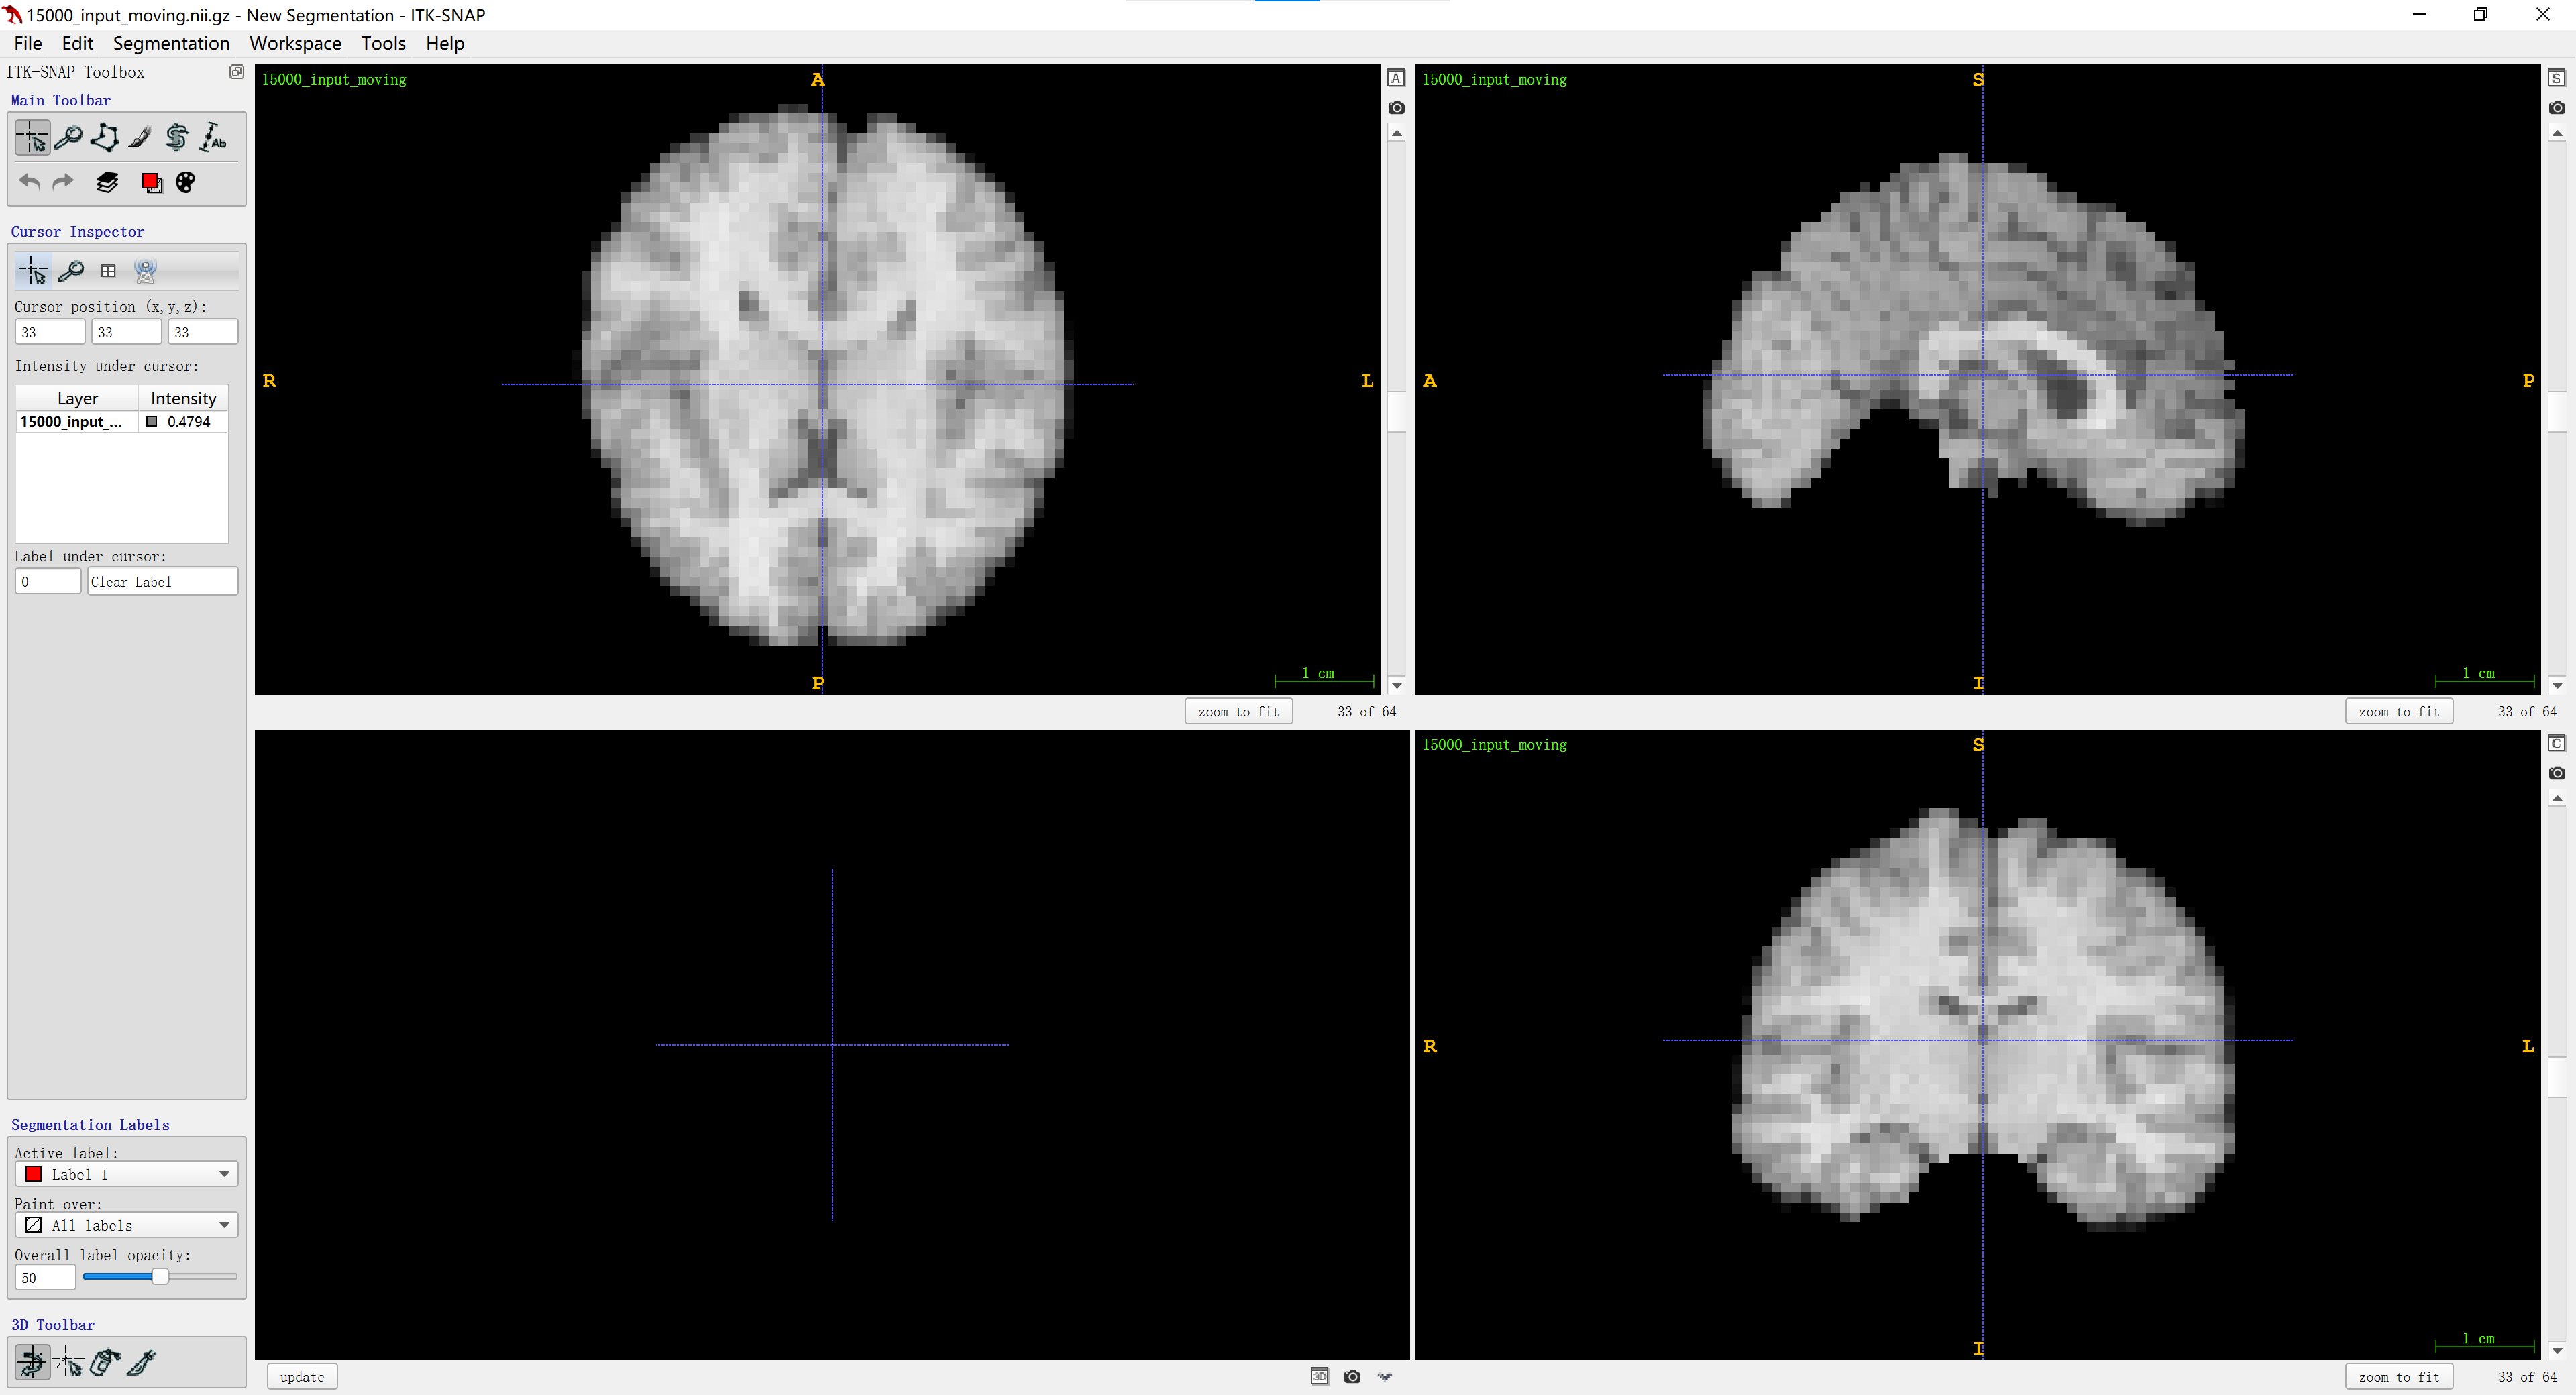

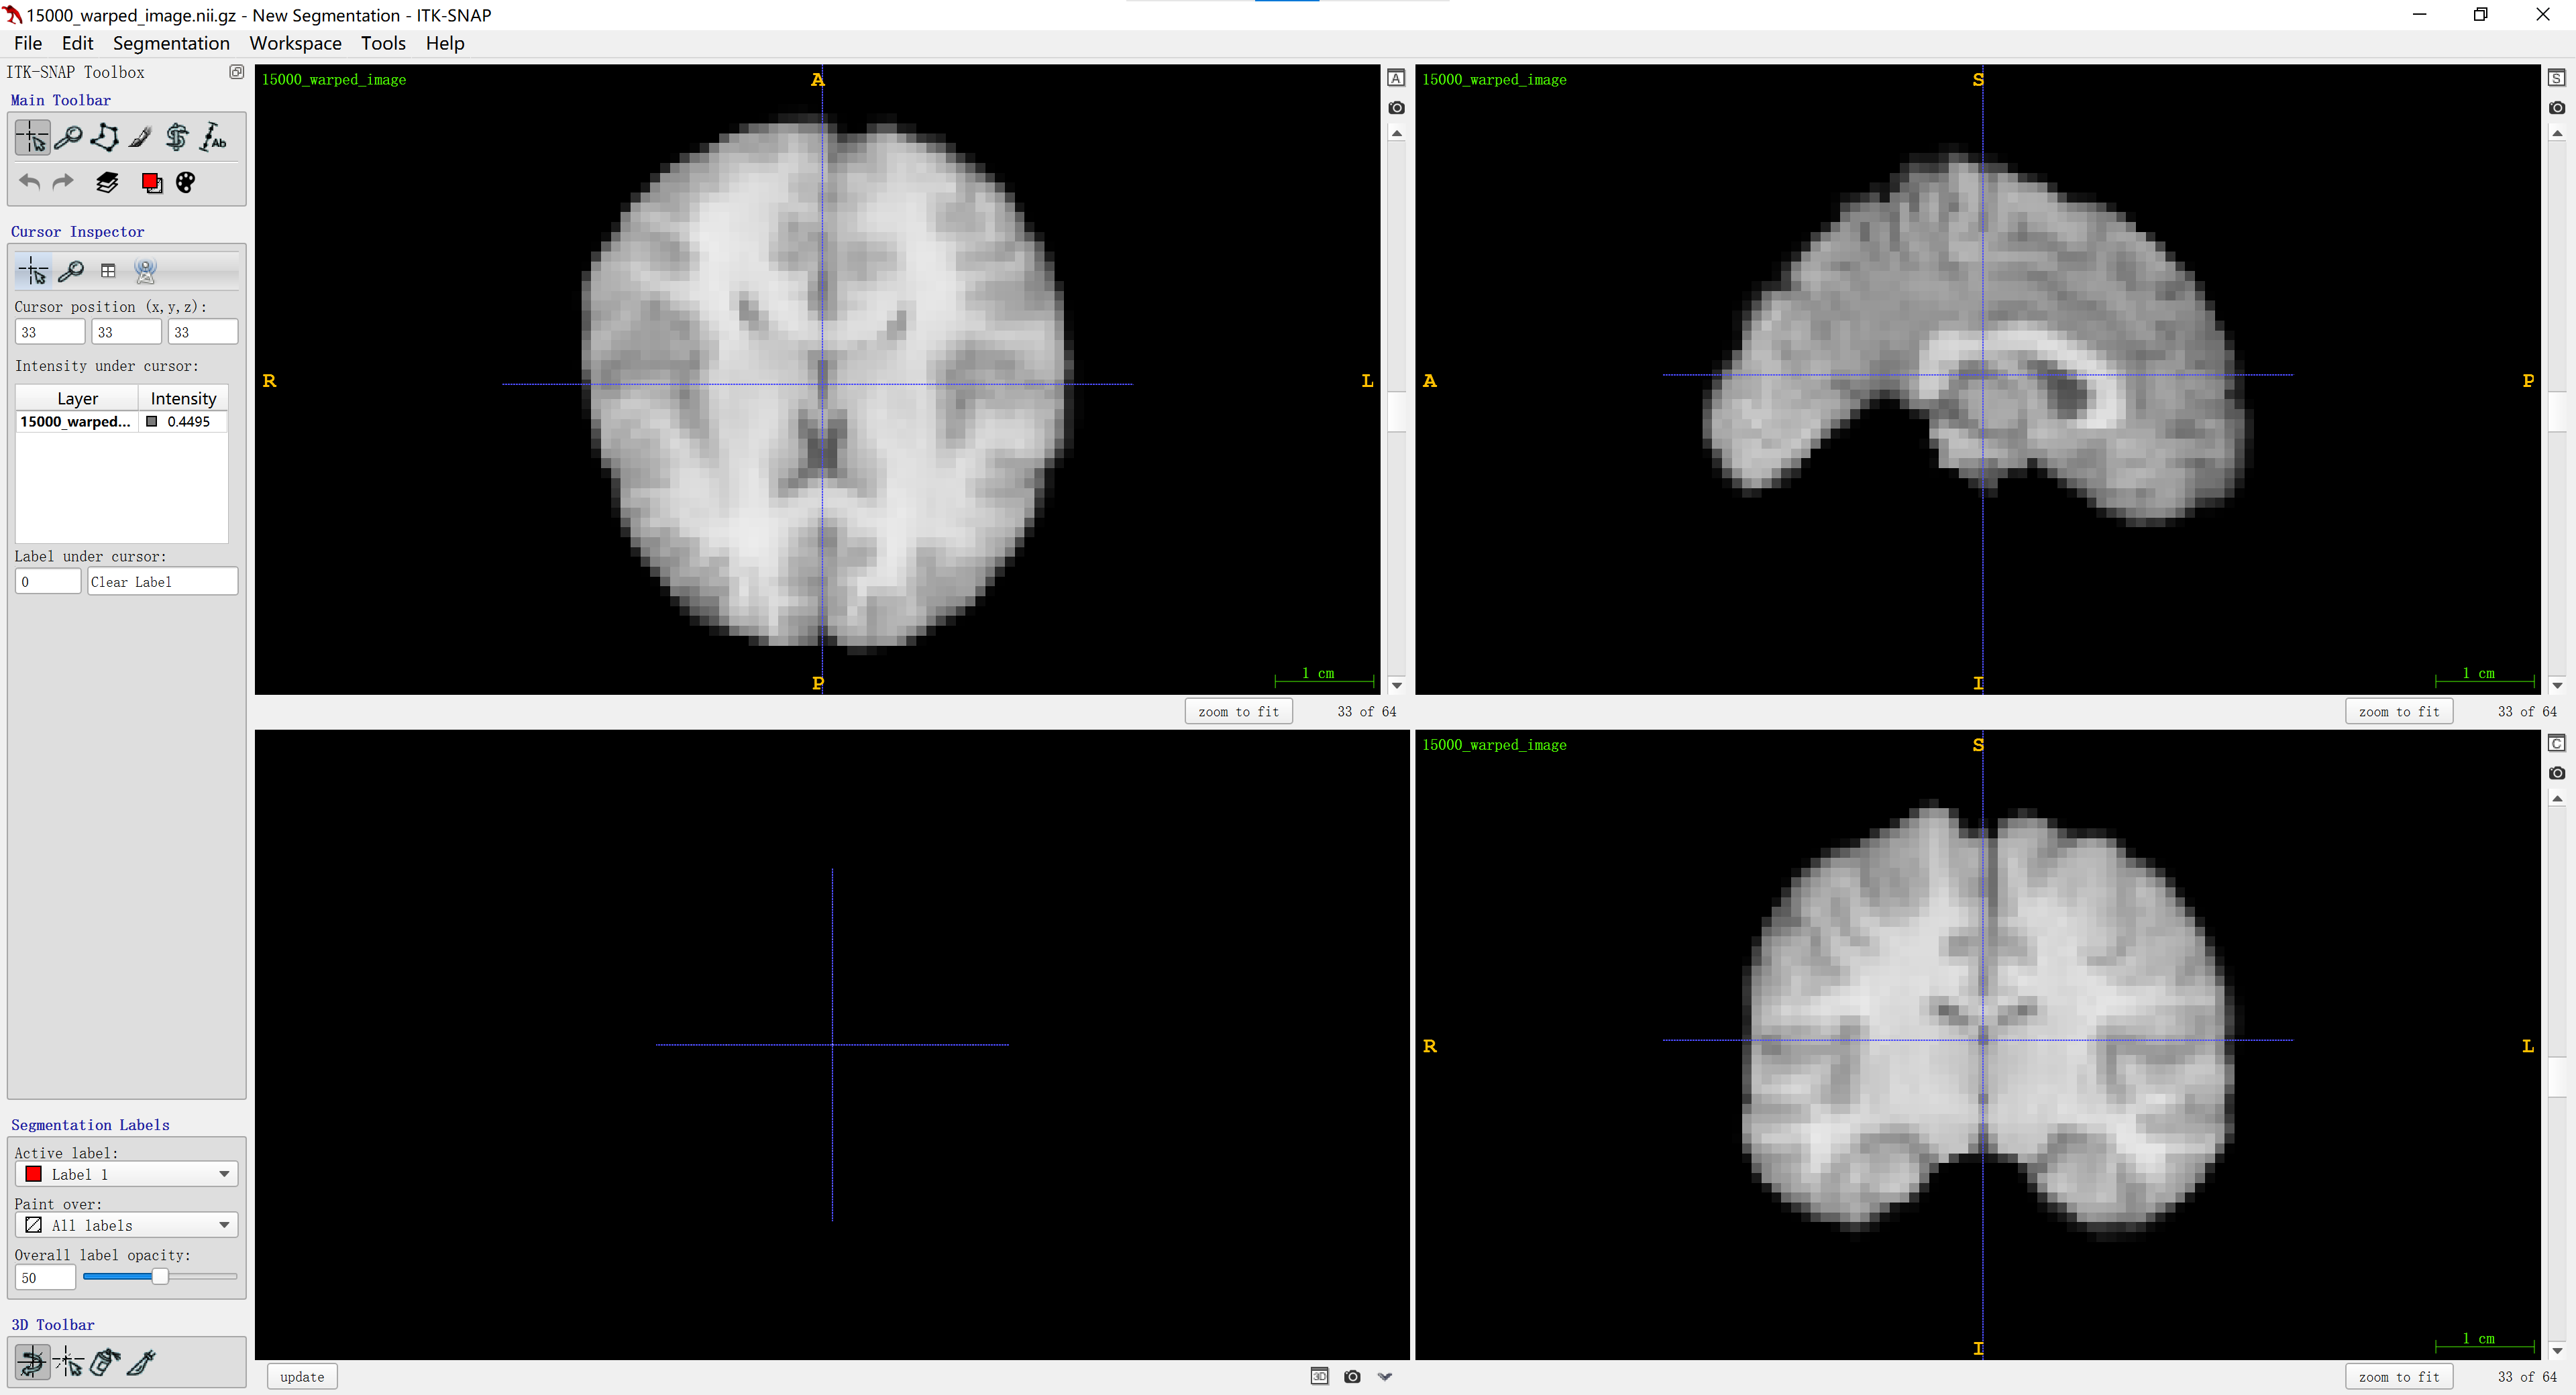

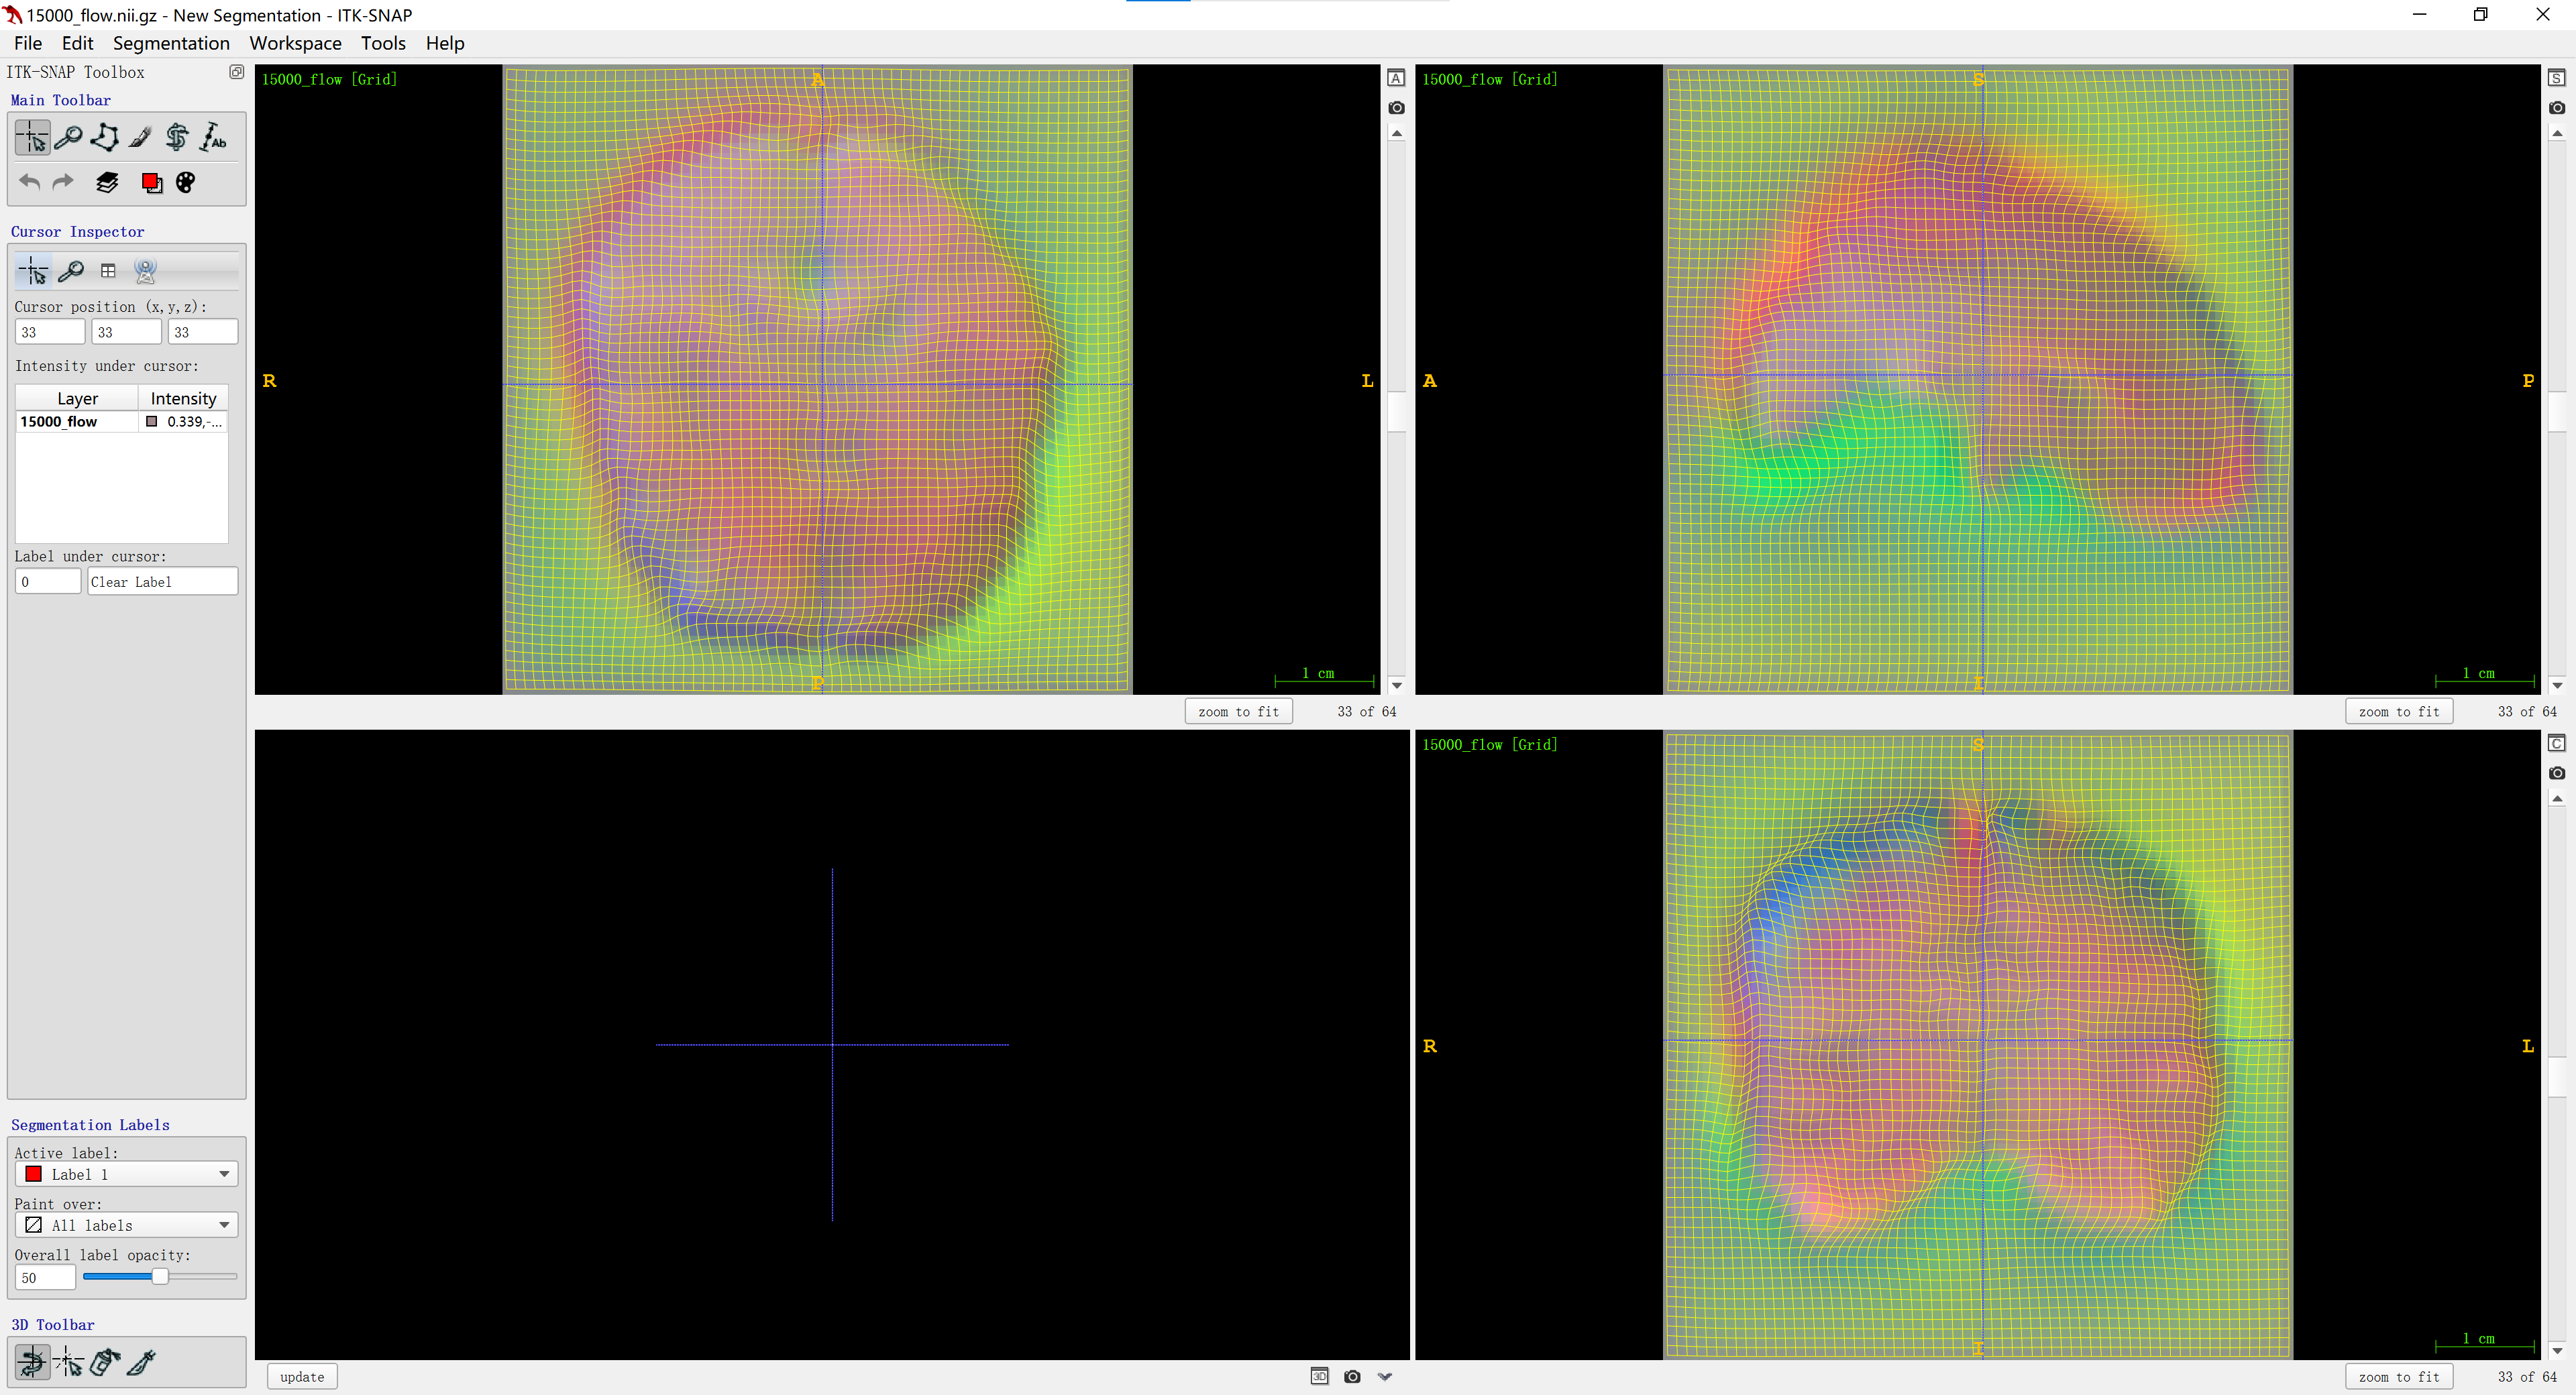

### 1.6 Improving performance (5 points)
Hint: Use the given masks corresponding to the training images as the auxiliary information for training the VoxelMorph model.

In [6]:
# # 在本文件最开始处已经将train和mask数据全部读入
# # 并且已经转换为ndarray
# # 将两者以0.5:0.5的权重进行相加
# trainItkImgsResizedMixed=0.5*trainItkImgsResized+0.5*maskItkImgsResized
# # 然后将其替换至原代码的训练数据处，重新进行训练

In [7]:
# # 模型训练
# # python imports
# import os
# import glob
# import warnings
# # external imports外源调用
# import torch
# import numpy as np
# import SimpleITK as sitk
# from torch.optim import Adam
# import torch.utils.data as Data
# from tqdm import tqdm

# # 如果没有，生成文件夹，不重要
# def make_dirs():
#     if not os.path.exists(model_dir):
#         os.makedirs(model_dir)
#     if not os.path.exists(log_dir):
#         os.makedirs(log_dir)
#     if not os.path.exists(result_dir):
#         os.makedirs(result_dir)

# # 保存图像的函数
# def save_image(img, ref_img, name):
#     img = sitk.GetImageFromArray(img[0, ...].cpu().detach().numpy())
#     img.SetOrigin(ref_img.GetOrigin())
#     img.SetDirection(ref_img.GetDirection())
#     img.SetSpacing(ref_img.GetSpacing())
#     sitk.WriteImage(img, os.path.join(result_dir, name))


# # 创建需要的文件夹并指定gpu
# make_dirs()
# device = torch.device('cuda:{}'.format(gpu) if torch.cuda.is_available() else 'cpu')

# # 读入fixed图像
# # f_img = sitk.ReadImage(atlas_file)
# f_img = sitk.GetImageFromArray(fixedImg[0,0,:,:,:])
# input_fixed=np.array(fixedImg)
# # 确定图像维度，本题是3维
# vol_size = input_fixed.shape[2:]
# # [B, C, D, W, H]【图像数/batch，通道，长，宽，高】
# # 把配准图像重复‘图像个数’次
# input_fixed = np.repeat(input_fixed, batch_size, axis=0)
# input_fixed = torch.from_numpy(input_fixed).to(device).float()

# # 创建配准网络（UNet）和STN形变场
# nf_enc = [16, 32, 32, 32]
# # 设置解码器网络结构参数
# nf_dec = [32, 32, 32, 32, 32, 16, 16]
# # 初始化Unet和形变场
# UNet = U_Network(len(vol_size), nf_enc, nf_dec).to(device)
# STN = SpatialTransformer(vol_size).to(device)

# # 设置优化器和损失函数
# opt = Adam(UNet.parameters(), lr=lr)
# sim_loss_fn = ncc_loss
# grad_loss_fn = NJ_loss

# # Get all the names of the training data
# DS=torch.tensor(trainItkImgsResizedMixed)
# print("Number of training images: ", len(DS)) #输出一下图片数量
# # 创建dataloader
# DL = Data.DataLoader(DS, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

# # 开始训练
# for i in tqdm(range(1, n_iter + 1)):
#     # Generate the moving images and convert them to tensors.
#     input_moving = iter(DL).next()
#     # [B, C, D, W, H]
#     input_moving = input_moving.to(device).float()

#     # Run the data through the model to produce warp and flow field
#     flow_m2f = UNet(input_moving, input_fixed)
#     flow=flow_m2f.permute(0,2,3,4,1)
#     m2f = STN(input_moving, flow_m2f)
#     warped_image=m2f[0,:,:,:,:]

#     # Calculate loss
#     sim_loss = sim_loss_fn(m2f, input_fixed)
#     grad_loss = grad_loss_fn(flow_m2f)
#     loss = sim_loss + alpha * grad_loss
# #         print("i: %d  loss: %f  sim: %f  grad: %f" % (i, loss.item(), sim_loss.item(), grad_loss.item()), flush=True)
# #         print("%d, %f, %f, %f" % (i, loss.item(), sim_loss.item(), grad_loss.item()), file=f)

#     # 反向传播并且优化参数
#     opt.zero_grad()
#     loss.backward()
#     opt.step()
#     # 设置多久保存一次模型参数以及配准图像结果
#     if i % n_save_iter == 0:
#         # Save model checkpoint
#         save_file_name = os.path.join(model_dir, '%d.pth' % i)
#         torch.save(UNet.state_dict(), save_file_name)
#         # Save images
#         warped_image_name = str(i) + "_warped_image.nii.gz"
#         flow_name = str(i) + "_flow.nii.gz"
#         save_image(warped_image, f_img, warped_image_name) #保存配准后的图像
#         save_image(flow, f_img, flow_name) #保存形变场
#         print("保存了配准后的图像和形变场")